# Semana 1

### Imports

In [2]:
# Semana 1
import wfdb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os

# Semana 2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay,
    classification_report,
)

### Cargar datos

In [4]:
# Cargar el archivo CSV con las features RR
df = pd.read_csv("..//data//ecg_rr_features_curado.csv")

# Quitar espacios en blanco por si acaso
df['label'] = df['label'].str.strip()

# Filtrar solo las clases que nos interesan: Normal y AFib
df_filtrado = df[df['label'].isin(['Normal', 'AFib'])]

# Mostrar conteo por clase
conteo = df_filtrado['label'].value_counts()
print("Distribución de clases:\n", conteo)

# Determinar el mínimo (por si alguna clase tiene menos de 15)
minimo = min(15, int(conteo.min()))

# Tomar muestras
muestra_normal = df_filtrado[df_filtrado['label'] == 'Normal'].sample(n=minimo, random_state=42)
muestra_afib = df_filtrado[df_filtrado['label'] == 'AFib'].sample(n=minimo, random_state=42)

# Combinar y mezclar
muestra_balanceada = pd.concat([muestra_normal, muestra_afib]).sample(frac=1, random_state=42).reset_index(drop=True)

# Guardar a CSV
muestra_balanceada.to_csv("..//data//ecg_muestra_balanceada.csv", index=False)

print("✅ Muestra balanceada creada con éxito: ecg_muestra_balanceada.csv")
print(muestra_balanceada['label'].value_counts())


Distribución de clases:
 label
Normal    5050
AFib       738
Name: count, dtype: int64
✅ Muestra balanceada creada con éxito: ecg_muestra_balanceada.csv
label
AFib      15
Normal    15
Name: count, dtype: int64


In [3]:
# Parámetro de frecuencia
fs = 300  # Hz

# === 1. Cargar etiquetas desde la muestra balanceada ===
df_ref = pd.read_csv('..//data//ecg_muestra_balanceada.csv')

# Renombrar columna si es necesario (asegurar que sea "id" y "label")
df_ref.columns = ['id', 'f1', 'f2', 'f3', 'f4', 'label']

# Filtrar clases válidas: solo "Normal" y "AFib"
df_ref = df_ref[df_ref['label'].isin(['Normal', 'AFib'])].reset_index(drop=True)

# Verificar contenido
print("✅ Datos cargados correctamente.\n")
print(df_ref.head())

✅ Datos cargados correctamente.

       id          f1          f2        f3        f4   label
0  A06397  613.546099  199.898797  1.168773  1.350203    AFib
1  A02900  383.244444  127.736967  1.619724  3.183308    AFib
2  A05366  531.851852   75.598209  0.668771  0.890665    AFib
3  A02375  577.687075  145.318797  1.677749  3.186396    AFib
4  A04689  999.642857   62.781678  1.335801  0.459524  Normal


### Inspeccion basica

In [4]:
print("\n--- Inspección básica ---")
print("\n.describe():")
print(df_ref.describe(include='all'))

print("\nTipos de datos:")
print(df_ref.dtypes)


--- Inspección básica ---

.describe():
            id           f1          f2         f3         f4 label
count       30    30.000000   30.000000  30.000000  30.000000    30
unique      30          NaN         NaN        NaN        NaN     2
top     A06397          NaN         NaN        NaN        NaN  AFib
freq         1          NaN         NaN        NaN        NaN    15
mean       NaN   802.005397   97.708348   0.106184   1.674042   NaN
std        NaN   245.209851   67.097005   1.341723   4.743288   NaN
min        NaN   383.244444   13.656897  -3.718210  -1.088567   NaN
25%        NaN   589.324904   39.889314  -0.482938  -0.743942   NaN
50%        NaN   796.694678   84.084199  -0.005178   0.406078   NaN
75%        NaN  1009.196429  141.262828   0.808692   1.684202   NaN
max        NaN  1216.666667  247.163042   3.944970  21.233389   NaN

Tipos de datos:
id        object
f1       float64
f2       float64
f3       float64
f4       float64
label     object
dtype: object


### Distribucion de la muestra

C:\Users\56984\AppData\Local\Temp\ipykernel_16128\4059101364.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_ref, x='label', palette='pastel')


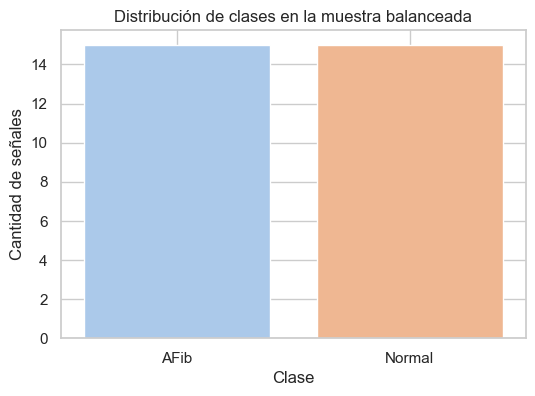

In [5]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=df_ref, x='label', palette='pastel')
plt.title('Distribución de clases en la muestra balanceada')
plt.xlabel('Clase')
plt.ylabel('Cantidad de señales')
plt.grid(True)
plt.show()


### Señales de electrocardiogramas (arritmia vs normal)

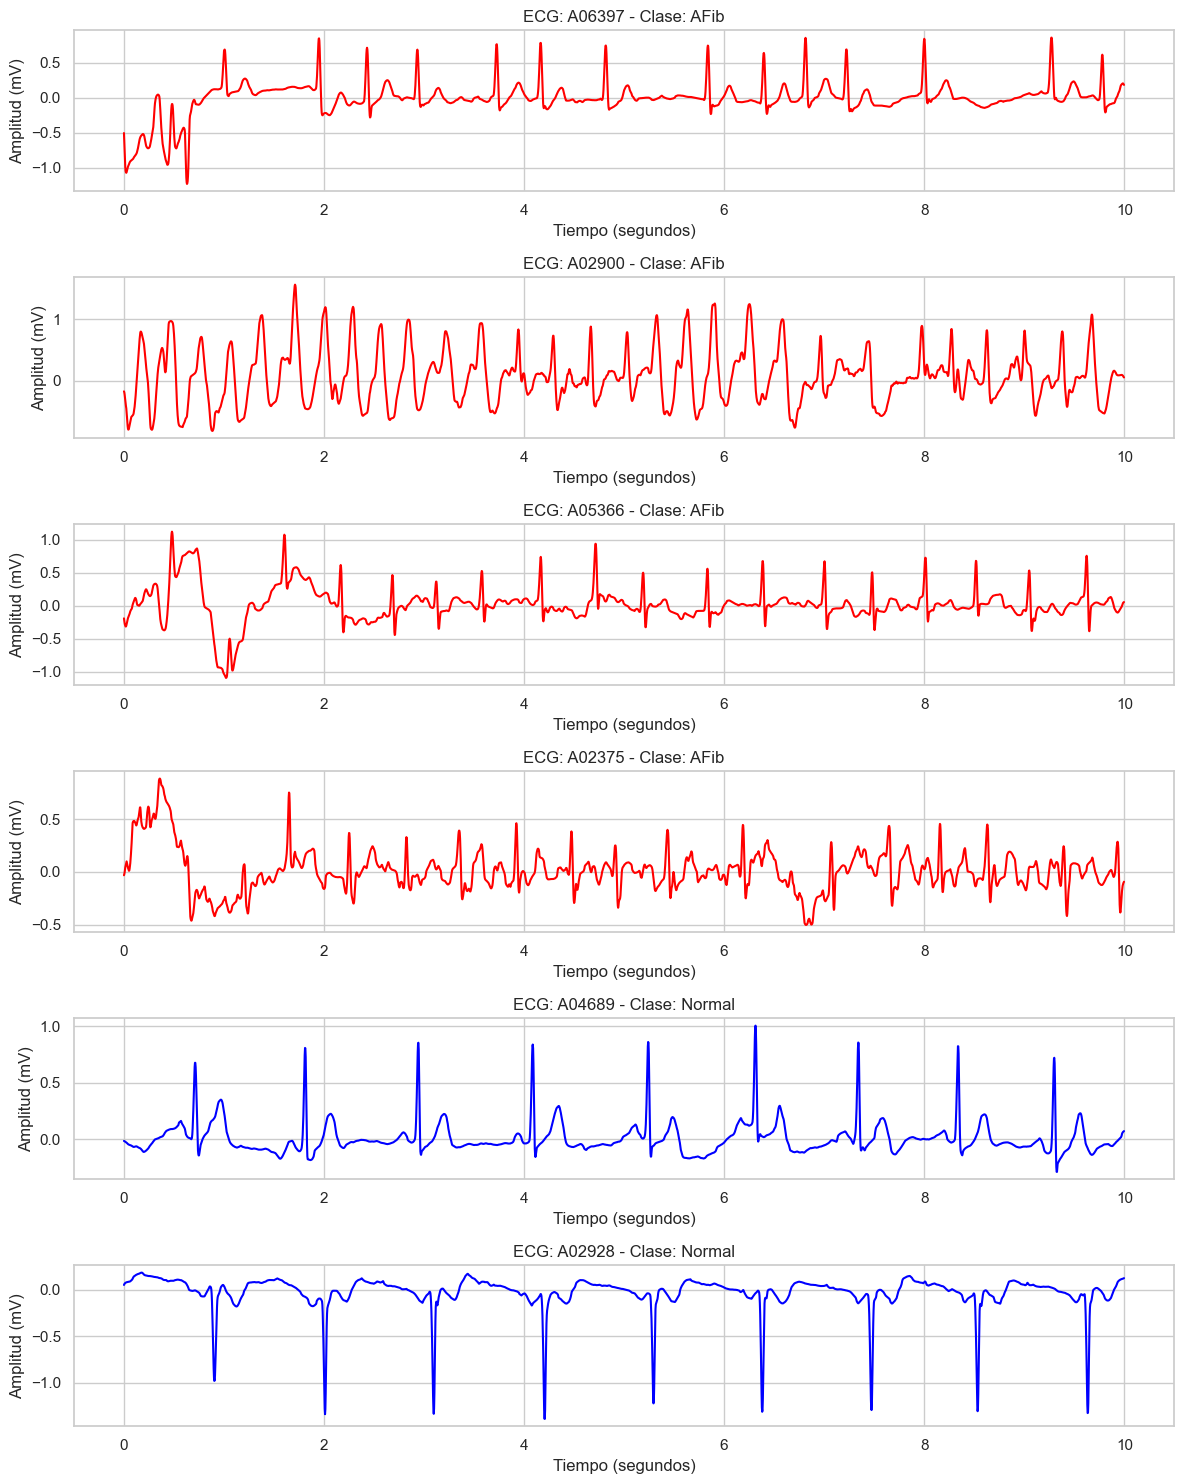

In [6]:
def mostrar_varias_senales(df, num=6, fs=300):
    plt.figure(figsize=(12, num * 2.5))
    ruta_ecg = "..//data//training2017"

    for i, row in df.head(num).iterrows():
        try:
            ruta_completa = os.path.join(ruta_ecg, row['id'])
            record = wfdb.rdrecord(ruta_completa)
            signal = record.p_signal[:fs * 10].flatten()  # primeros 10 segundos
            tiempo = np.arange(len(signal)) / fs

            plt.subplot(num, 1, i + 1)
            plt.plot(tiempo, signal, color='blue' if row['label'] == 'Normal' else 'red')
            plt.title(f"ECG: {row['id']} - Clase: {row['label']}")
            plt.xlabel("Tiempo (segundos)")
            plt.ylabel("Amplitud (mV)")
            plt.grid(True)
        except Exception as e:
            print(f"⚠️ No se pudo cargar {row['id']}: {e}")
            continue

    plt.tight_layout()
    plt.show()
    
# Mostrar señales
mostrar_varias_senales(df_ref, num=6, fs=fs)


### Histogramas

Resumen del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       30 non-null     object 
 1   mean_rr  30 non-null     float64
 2   std_rr   30 non-null     float64
 3   skew_rr  30 non-null     float64
 4   kurt_rr  30 non-null     float64
 5   label    30 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.5+ KB
None

Primeras filas:
       id     mean_rr      std_rr   skew_rr   kurt_rr   label
0  A06397  613.546099  199.898797  1.168773  1.350203    AFib
1  A02900  383.244444  127.736967  1.619724  3.183308    AFib
2  A05366  531.851852   75.598209  0.668771  0.890665    AFib
3  A02375  577.687075  145.318797  1.677749  3.186396    AFib
4  A04689  999.642857   62.781678  1.335801  0.459524  Normal

Resumen estadístico:
           mean_rr      std_rr    skew_rr    kurt_rr
count    30.000000   30.000000  30.000000  30.00000

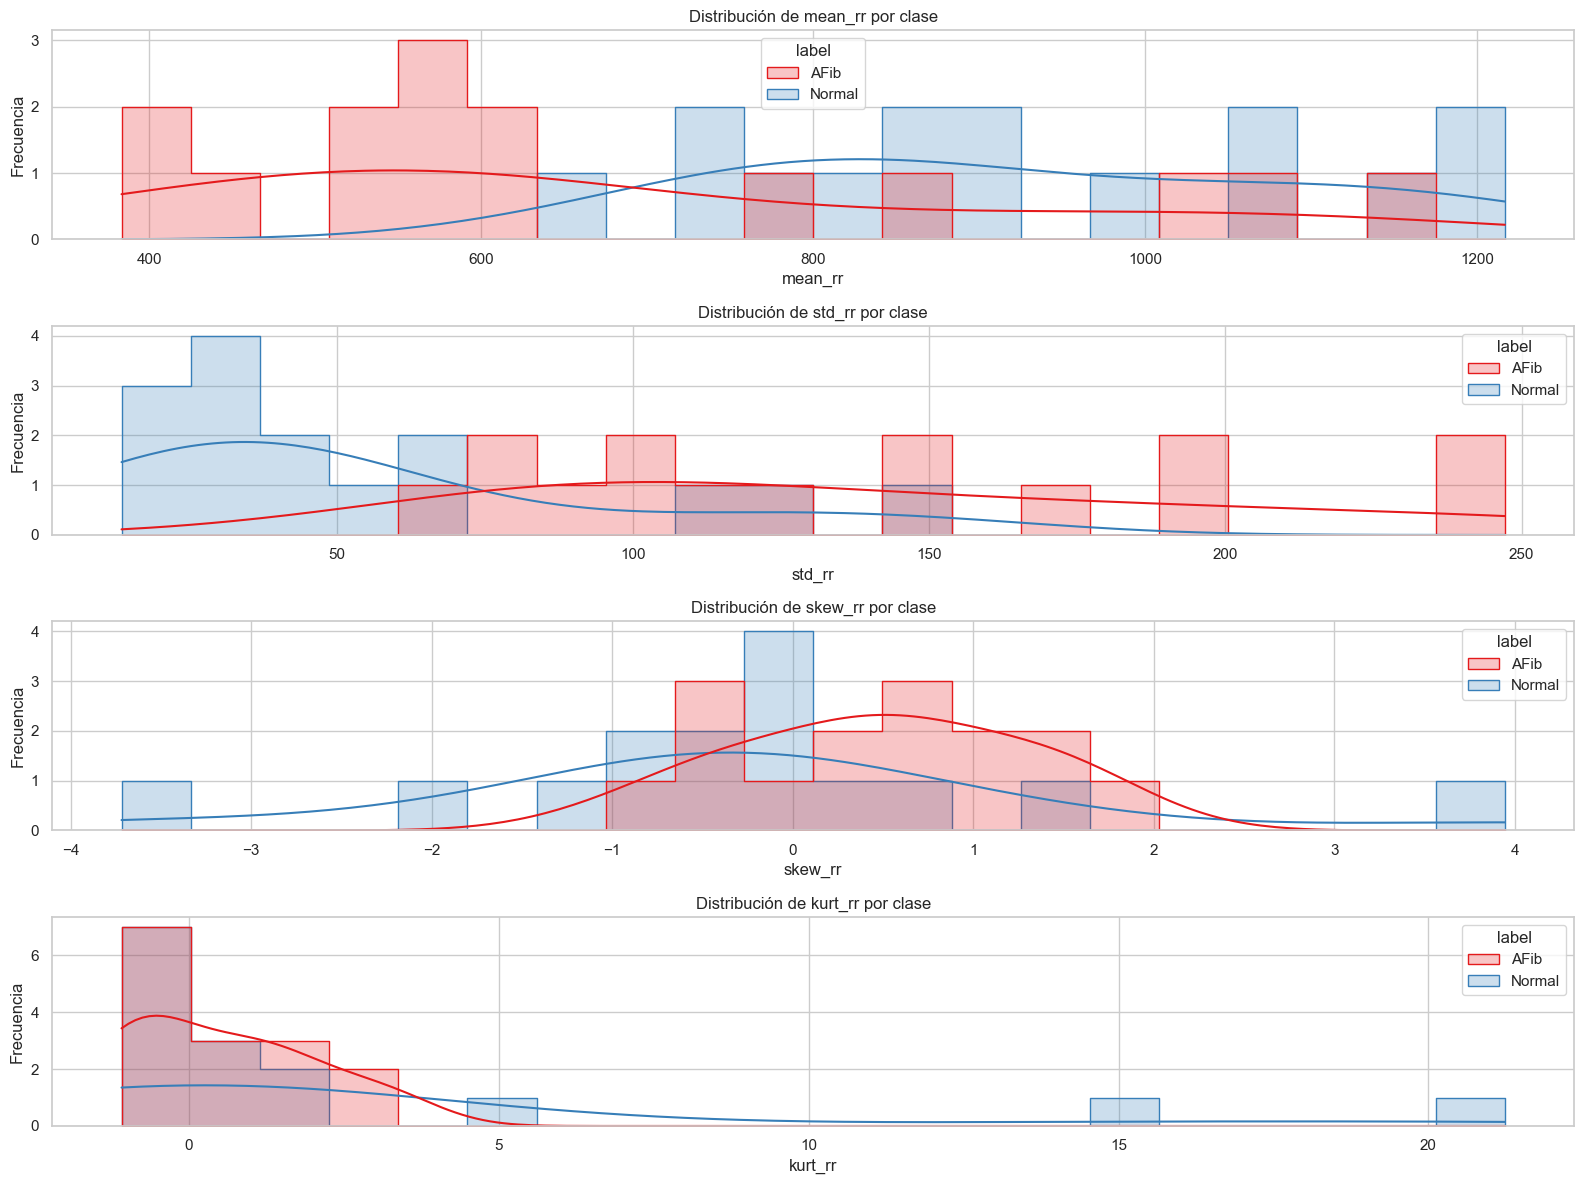

In [7]:
# Cargar la muestra balanceada
df = pd.read_csv("..//data//ecg_muestra_balanceada.csv")

# Mostrar una inspección rápida
print("Resumen del dataset:\n")
print(df.info())
print("\nPrimeras filas:")
print(df.head())
print("\nResumen estadístico:")
print(df.describe())

# Obtener solo las columnas numéricas (excluyendo la etiqueta)
features = df.select_dtypes(include='number').columns

# Configurar estilo
sns.set(style="whitegrid")
plt.figure(figsize=(16, len(features) * 3))

# Generar un histograma por cada feature
for i, feature in enumerate(features):
    plt.subplot(len(features), 1, i + 1)
    sns.histplot(data=df, x=feature, hue="label", kde=True, element="step", palette='Set1', bins=20)
    plt.title(f'Distribución de {feature} por clase')
    plt.xlabel(feature)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Conclusiones

- Algunas variables como **rmssd** y **pnn50** muestran diferencias notables entre clases (por ejemplo, AFib tiende a tener valores mayores).
- La variable **mean_rr** también presenta una distribución distinta en pacientes con fibrilación auricular (ritmos más irregulares).
- Se observan **outliers** en algunas variables como `nn50`, lo cual podría reflejar la variabilidad extrema en ciertos casos.
- En general, el dataset está limpio, bien etiquetado, y permite ya desde esta etapa observar **tendencias diferenciadoras** entre ritmo normal y AFib, lo que será útil para entrenar clasificadores más adelante.


# Semana 2

=== Métricas de Evaluación ===
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1-score:  1.0000

Reporte completo:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00         5
        AFib       1.00      1.00      1.00         4

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



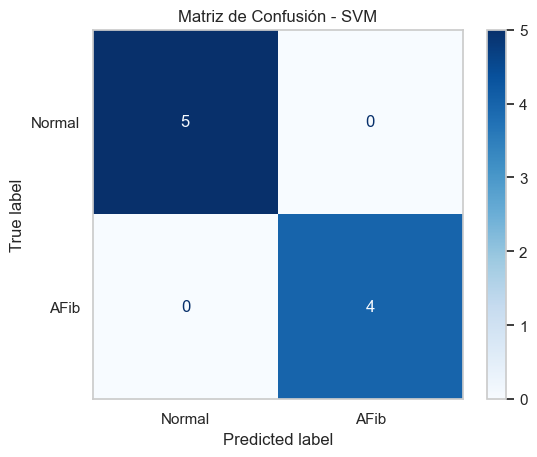

In [16]:
# Cargar datos
df = pd.read_csv("..//data//ecg_muestra_balanceada.csv")

# Filtrar solo clases válidas
df = df[df['label'].isin(['Normal', 'AFib'])]

# Separar features y etiquetas
X = df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
y = df['label']

# Convertir etiquetas a numéricas (opcional para algunos clasificadores)
y = y.map({'Normal': 0, 'AFib': 1})



# Separar en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


# Estandarizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Entrenar modelo SVM
clf = SVC(kernel='rbf', random_state=42)
clf.fit(X_train_scaled, y_train)


# Evaluar desempeño
y_pred = clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


# Reporte y matriz de confusión
print("=== Métricas de Evaluación ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print("\nReporte completo:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'AFib']))

ConfusionMatrixDisplay.from_estimator(
    clf, X_test_scaled, y_test, display_labels=['Normal', 'AFib'], cmap="Blues"
)
plt.title("Matriz de Confusión - SVM")
plt.grid(False)
plt.show()


###  Resultados del modelo SVM – Análisis

**Métricas de evaluación**  
El modelo logró un desempeño perfecto en el conjunto de prueba, con métricas de evaluación que alcanzan el valor máximo en todos los casos:

- **Accuracy**: 1.00  
- **Precision**: 1.00  
- **Recall**: 1.00  
- **F1-Score**: 1.00  

Esto indica que el modelo clasificó correctamente todos los registros, tanto de clase Normal como de AFib.

**Matriz de confusión**  
- 5 registros de clase **Normal** fueron correctamente clasificados como **Normal**.  
- 4 registros de clase **AFib** fueron clasificados correctamente como **AFib**.  
- No se produjeron falsos positivos ni falsos negativos.

**Análisis general**  
El modelo SVM logró una separación perfecta entre ambas clases en este conjunto de prueba. Esto sugiere que las características utilizadas (como `mean_rr`, `std_rr`, `skew_rr`, etc.) son muy representativas para distinguir entre señales normales y de fibrilación auricular.

Sin embargo, es importante tener presente que el tamaño del conjunto de prueba es reducido (solo 9 muestras en total). Un rendimiento perfecto con tan pocos ejemplos podría no reflejar el comportamiento real del modelo frente a nuevos datos, por lo que existe el riesgo de sobreajuste o de que el conjunto de prueba no sea suficientemente desafiante.

**Siguientes pasos recomendados**    
- Probar con un conjunto de datos más amplio y representativo.


### Visualización de errores
En este caso, al evaluar el modelo con el conjunto de prueba (9 señales), no se identificaron errores de clasificación:

5 señales normales fueron clasificadas correctamente.

4 señales de AFib también fueron identificadas correctamente.

0 errores: no se produjeron ni falsos positivos ni falsos negativos.




La cantidad de ejemplos es muy baja, por lo que la probabilidad de obtener resultados “perfectos” por casualidad aumenta. Con un conjunto de prueba más amplio, podrían aparecer errores que aquí no se muestran

Otra mejora podria ser Normalización o estandarización
Asegurarse de que las features estén en la misma escala puede beneficiar a modelos como SVM, dandole mas precisión al modelo, aceleraria la convergencia y lo coeficientes del modelo serian mas interpretables.

Tambien se podrian agregar mas features, como por ejemplo la energia de la señal o duración de intervalos si se tiene segmentación.

Y por ultimo cuando aparezcan errores en conjuntos más grandes, se podrían visualizar ejemplos mal clasificados, graficando su señal original para entender qué características pudieron causar confusión.

Incluir mas clases: Añadir las clases “O” y “~” para reflejar mejor diversidad real de ritmos cardiacos.